<a href="https://colab.research.google.com/github/ankishb/To-Do-List/blob/master/test_undeepvo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf


def spatial_transform(input_images, x_offset, wrap_mode='border', name='bilinear_sampler', **kwargs):
    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.tile(tf.expand_dims(x, 1), [1, n_repeats])
            return tf.reshape(rep, [-1])

    def _interpolate(im, x, y):
        with tf.variable_scope('_interpolate'):

            # handle both texture border types
            _edge_size = 0
            if _wrap_mode == 'border':
                _edge_size = 1
                im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
                x = x + _edge_size
                y = y + _edge_size
            elif _wrap_mode == 'edge':
                _edge_size = 0
            else:
                return None

            x = tf.clip_by_value(x, 0.0, _width_f - 1 + 2 * _edge_size)

            x0_f = tf.floor(x)
            y0_f = tf.floor(y)
            x1_f = x0_f + 1

            x0 = tf.cast(x0_f, tf.int32)
            y0 = tf.cast(y0_f, tf.int32)
            x1 = tf.cast(tf.minimum(x1_f, _width_f - 1 + 2 * _edge_size), tf.int32)

            dim2 = (_width + 2 * _edge_size)
            dim1 = (_width + 2 * _edge_size) * (_height + 2 * _edge_size)
            base = _repeat(tf.range(_num_batch) * dim1, _height * _width)
            base_y0 = base + y0 * dim2
            idx_l = base_y0 + x0
            idx_r = base_y0 + x1

            im_flat = tf.reshape(im, tf.stack([-1, _num_channels]))

            pix_l = tf.gather(im_flat, idx_l)
            pix_r = tf.gather(im_flat, idx_r)

            weight_l = tf.expand_dims(x1_f - x, 1)
            weight_r = tf.expand_dims(x - x0_f, 1)

            return weight_l * pix_l + weight_r * pix_r

    def _transform(input_images, x_offset):
        with tf.variable_scope('transform'):
            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            x_t, y_t = tf.meshgrid(tf.linspace(0.0, _width_f - 1.0, _width),
                                   tf.linspace(0.0, _height_f - 1.0, _height))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            x_t_flat = tf.tile(x_t_flat, tf.stack([_num_batch, 1]))
            y_t_flat = tf.tile(y_t_flat, tf.stack([_num_batch, 1]))

            x_t_flat = tf.reshape(x_t_flat, [-1])
            y_t_flat = tf.reshape(y_t_flat, [-1])

            x_t_flat = x_t_flat + tf.reshape(x_offset, [-1]) * _width_f

            input_transformed = _interpolate(input_images, x_t_flat, y_t_flat)

            output = tf.reshape(
                input_transformed, tf.stack([_num_batch, _height, _width, _num_channels]))
            return output

    with tf.variable_scope(name):
        _num_batch = tf.shape(input_images)[0]
        _height = tf.shape(input_images)[1]
        _width = tf.shape(input_images)[2]
        _num_channels = tf.shape(input_images)[3]

        _height_f = tf.cast(_height, tf.float32)
        _width_f = tf.cast(_width, tf.float32)

        _wrap_mode = wrap_mode

        output = _transform(input_images, x_offset)
        return output


In [0]:
img = tf.placeholder(shape=(None,5,5,3),dtype="float32")
off = tf.placeholder(shape=(None,5,5,1), dtype="float32")

spat = spatial_transform(img, off)

In [0]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [7]:
import numpy as np

a = np.random.randn(1,5,5,3)
b = np.random.randn(1,5,5,1)
a.shape, b.shape

((1, 5, 5, 3), (1, 5, 5, 1))

In [0]:
out = sess.run([spat], feed_dict={img:a, off:b})

In [13]:
out[0].shape

(1, 5, 5, 3)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


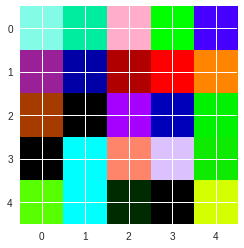

In [16]:
plt.imshow(a[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


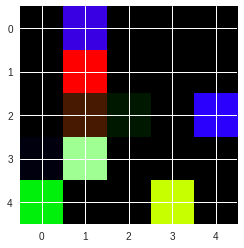

In [17]:
plt.imshow(out[0][0])

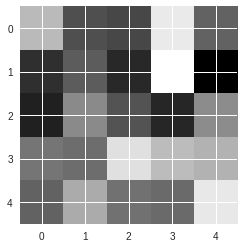

In [19]:
plt.imshow(b.reshape(5,5))

In [0]:
from keras.layers import Lambda
# from util import spatial_transform
import keras.backend as K


def spatial_transformation(inputs, sign):
    def output_shape(input_shape):

        return input_shape[0]

    return Lambda(lambda x: spatial_transform(x[0], sign*x[1]), output_shape=output_shape)(inputs)


def expand_dims(inputs, dimension):
    def output_shape(input_shape):
        shape = list(input_shape)

        shape[3] = 1

        return tuple(shape)

    return Lambda(lambda x: K.expand_dims(inputs[:, :, :, dimension], 3), output_shape=output_shape)(inputs)


def depth_to_disparity(inputs, baseline, focal_length):
    def output_shape(input_shape):
        return input_shape

    return Lambda(lambda x: baseline * focal_length / x, output_shape=output_shape)(inputs)


def disparity_difference(disparities):
    def output_shape(input_shape):
        return input_shape

    return Lambda(lambda x: x[0] - x[1], output_shape=output_shape)(disparities)

In [0]:
# from keras.layers import Lambda
from keras.losses import mean_absolute_error
import keras.backend as K

alpha = 0.85


def ssim(x, y):
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    mu_x = K.mean(x, axis=-1)
    mu_y = K.mean(y, axis=-1)

    sigma_x = K.mean(x**2, axis=-1) - mu_x**2
    sigma_y = K.mean(y**2, axis=-1) - mu_y**2
    sigma_xy = K.mean(x * y, axis=-1) - mu_x * mu_y

    ssim_n = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    ssim_d = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x + sigma_y + c2)

    ssim_out = ssim_n / ssim_d

    return K.clip((1-ssim_out)/2, 0, 1)
    # return Lambda(lambda x: K.clip((1-x)/2, 0, 1))(ssim_out)


def photometric_consistency_loss(y_true, y_pred):
    return alpha*ssim(y_true, y_pred) + (1 - alpha)*mean_absolute_error(y_true, y_pred)

In [0]:
from keras.optimizers import Adadelta
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, concatenate
# from layers import depth_to_disparity, disparity_difference, expand_dims, spatial_transformation
# from losses import photometric_consistency_loss


class UnDeepVOModel(object):
    def __init__(self, left_input, right_input, mode='train'):
        # depth = baseline * focal / disparity
        # depth = 0.54 * 721 / (1242 * disp)

        self.baseline = 0.54  # meters

        self.focal_length = 718.856 / 1241  # image width = 1241 (note: must scale using this number)

        self.left = left_input

        self.right = right_input

        self.left_est = None

        self.right_est = None

        self.depthmap = None

        self.depthmap_left = None

        self.depthmap_right = None

        self.disparity_left = None

        self.disparity_right = None

        self.disparity_diff_left = None

        self.disparity_diff_right = None

        self.right_to_left_disparity = None

        self.left_to_right_disparity = None

        self.model_input = None

        self.model = None

        self.depthmap = None

        self.mode = mode

        self.build_architecture()

        self.build_outputs()

        self.build_model()

        if self.mode == 'test':
            return

    @staticmethod
    def conv(input, channels, kernel_size, strides, activation='elu'):

        return Conv2D(channels, kernel_size=kernel_size, strides=strides, padding='same', activation=activation)(input)

    @staticmethod
    def deconv(input, channels, kernel_size, scale):

        return Conv2DTranspose(channels, kernel_size=kernel_size, strides=scale, padding='same')(input)

    def conv_block(self, input, channels, kernel_size):
        conv1 = self.conv(input, channels, kernel_size, 1)

        conv2 = self.conv(conv1, channels, kernel_size, 2)

        return conv2

    def deconv_block(self, input, channels, kernel_size, skip):
        deconv1 = self.deconv(input, channels, kernel_size, 2)

        if skip is not None:
            concat1 = concatenate([deconv1, skip], 3)
        else:
            concat1 = deconv1

        iconv1 = self.conv(concat1, channels, kernel_size, 1)

        return iconv1

    def get_depth(self, input):
        return self.conv(input, 2, 3, 1, 'sigmoid')

    def build_architecture(self):
        self.model_input = self.left

        # encoder
        conv1 = self.conv_block(self.model_input, 32, 7)
        conv2 = self.conv_block(conv1, 64, 5)
        conv3 = self.conv_block(conv2, 128, 3)
        conv4 = self.conv_block(conv3, 256, 3)
        conv5 = self.conv_block(conv4, 256, 3)
        conv6 = self.conv_block(conv5, 256, 3)
        conv7 = self.conv_block(conv6, 256, 3)

        # skips
        skip1 = conv1
        skip2 = conv2
        skip3 = conv3
        skip4 = conv4
        skip5 = conv5
        skip6 = conv6

        deconv7 = self.deconv_block(conv7, 256, 3, skip6)
        deconv6 = self.deconv_block(deconv7, 256, 3, skip5)
        deconv5 = self.deconv_block(deconv6, 256, 3, skip4)
        deconv4 = self.deconv_block(deconv5, 128, 3, skip3)
        deconv3 = self.deconv_block(deconv4, 64, 3, skip2)
        deconv2 = self.deconv_block(deconv3, 32, 3, skip1)
        deconv1 = self.deconv_block(deconv2, 16, 3, None)
        
        self.depthmap = self.get_depth(deconv1)

    def build_outputs(self):

        # store depthmaps
        self.depthmap_left = expand_dims(self.depthmap, 0)
        self.depthmap_right = expand_dims(self.depthmap, 1)

        if self.mode == 'test':
            return

        # generate disparities
        self.disparity_left = depth_to_disparity(self.depthmap_left, self.baseline, self.focal_length)
        self.disparity_right = depth_to_disparity(self.depthmap_right, self.baseline, self.focal_length)

        # generate estimates of left and right images
        self.left_est = spatial_transformation([self.right, self.disparity_left], -1)
        self.right_est = spatial_transformation([self.left, self.disparity_right], 1)

        # generate left - right consistency
        self.right_to_left_disparity = spatial_transformation([self.disparity_right, self.disparity_left], -1)
        self.left_to_right_disparity = spatial_transformation([self.disparity_left, self.disparity_right], 1)
        self.disparity_diff_left = disparity_difference([self.disparity_left, self.right_to_left_disparity])
        self.disparity_diff_right = disparity_difference([self.disparity_right, self.left_to_right_disparity])

    def build_model(self):
        self.model = Model(inputs=[self.left, self.right], outputs=[self.left_est,
                                                                    self.right_est,
                                                                    self.disparity_diff_left,
                                                                    self.disparity_diff_right])
        self.model.compile(loss=[photometric_consistency_loss,
                                 photometric_consistency_loss,
                                 'mean_absolute_error',
                                 'mean_absolute_error'],
                           optimizer=Adadelta(),
                           metrics=['accuracy'])


In [0]:
import os
# from keras.utils import plot_model
from keras import backend as K
from keras.layers import Input
# from undeepvo_model import UnDeepVOModel


def main():

    batch_size = 5
    epochs = 100
    # img_rows, img_cols = 128, 416
    img_rows, img_cols = 128, 512
    model_dir = 'models'
    model_name = 'undeepvo'
#     model_path = os.path.join(model_dir, model_name)

    input_shape = (img_rows, img_cols, 3)

    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = UnDeepVOModel(left_input, right_input)

    print( model.model.summary())
    return model

In [29]:
model = main()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 512, 32) 4736        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 256, 32)  50208       conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 256, 64)  51264       conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


def get_stereo_image_generators(train_folder, test_folder, img_rows=128, img_cols=512, batch_size=16, shuffle=True):
    train_image_gen = ImageDataGenerator(rescale=1.0 / 255.0,
                                         rotation_range=5,
                                         shear_range=0.01,
                                         zoom_range=0.01,
                                         height_shift_range=0.01,
                                         width_shift_range=0.01)

    test_image_gen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_generator_left = train_image_gen.flow_from_directory(train_folder,
                                                               target_size=(img_rows, img_cols),
                                                               batch_size=batch_size,
                                                               seed=10,
                                                               shuffle=shuffle,
                                                               classes=['left'],
                                                               class_mode=None,
                                                               follow_links=True)

    train_generator_right = train_image_gen.flow_from_directory(train_folder,
                                                                target_size=(img_rows, img_cols),
                                                                batch_size=batch_size,
                                                                seed=10,
                                                                shuffle=shuffle,
                                                                classes=['right'],
                                                                class_mode=None,
                                                                follow_links=True)

    test_generator_left = test_image_gen.flow_from_directory(test_folder,
                                                             target_size=(img_rows, img_cols),
                                                             batch_size=batch_size,
                                                             seed=10,
                                                             shuffle=shuffle,
                                                             classes=['left'],
                                                             class_mode=None,
                                                             follow_links=True)

    test_generator_right = test_image_gen.flow_from_directory(test_folder,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              seed=10,
                                                              shuffle=shuffle,
                                                              classes=['right'],
                                                              class_mode=None,
                                                              follow_links=True)

    def train_generator_func():
        while True:
            left_image = train_generator_left.next()
            right_image = train_generator_right.next()
            yield [left_image, right_image], [left_image,
                                              right_image,
                                              np.zeros(shape=left_image.shape),
                                              np.zeros(shape=right_image.shape)]

    def test_generator_func():
        while True:
            left_image = test_generator_left.next()
            right_image = test_generator_right.next()
            yield [left_image, right_image], [left_image,
                                              right_image,
                                              np.zeros(shape=left_image.shape),
                                              np.zeros(shape=right_image.shape)]

    train_generator = train_generator_func()
    test_generator = test_generator_func()
    train_length = len(train_generator_left.filenames)
    test_length = len(test_generator_left.filenames)

    return train_generator, test_generator, train_length, test_length

In [0]:
# from layers import spatial_transformation
import matplotlib.image as mpimg
import numpy as np
from keras import backend as K
# from image_loader import get_stereo_image_generators
import matplotlib.pyplot as plt

img_rows, img_cols = 128, 512

# image_generator = get_stereo_image_generators('data/dataset/sequences/02/', batch_size=1, shuffle=True)
# img = image_generator.__next__()

# spatial transformation lambda layer test


In [34]:
import pandas as pd

df = pd.read_csv('sample_data/mnist_train_small.csv')
df.shape

(19999, 785)

In [39]:
img = df.iloc[0]
img = img[1:].reshape(28,28)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


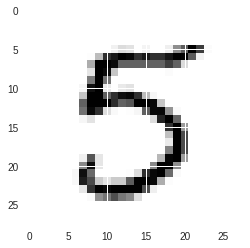

In [38]:
plt.imshow(img[1:].reshape(28,28))

In [65]:
512-242-243-1

26

In [0]:
img1 = np.zeros((128,512))

ii, jj = 0,0
for i in range(51,128-50):
    jj = 0
    for j in range(243,512-242):
#         print(i,j, ii, jj)
        img1[i][j] = img[ii][jj]
#         print(img[ii][jj])
        jj += 1
    ii += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


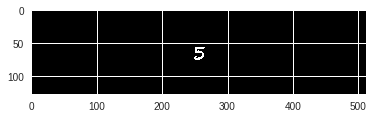

In [74]:
img2 = np.repeat(img1,3).reshape(128,512,3)#.shape
plt.imshow(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


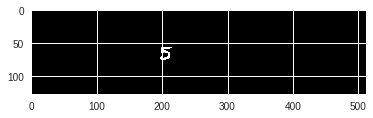

In [77]:
left_image = np.expand_dims(img2, axis=0)#img[0][0]
disparity = 0.1 * np.ones((1, img_rows, img_cols, 1))

disparity = K.variable(disparity)
left_image = K.variable(left_image)

right_image = spatial_transformation([left_image, disparity], 1)

im_right = K.eval(right_image)
plt.imshow(im_right[0])
plt.show()

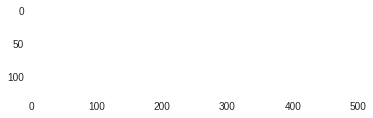

In [80]:
dis = 0.1 * np.ones((img_rows, img_cols))
plt.imshow(dis)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


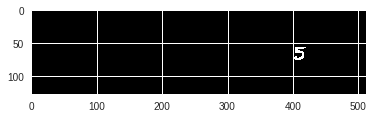

In [87]:
left_image = np.expand_dims(img2, axis=0)#img[0][0]
disparity = -0.3 * np.ones((1, img_rows, img_cols, 1))

disparity = K.variable(disparity)
left_image = K.variable(left_image)

right_image = spatial_transformation([left_image, disparity], 1)

im_right = K.eval(right_image)
plt.imshow(im_right[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


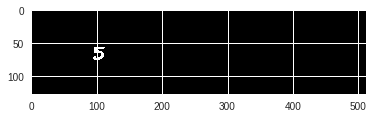

In [88]:
left_image = np.expand_dims(img2, axis=0)#img[0][0]
disparity = 0.3 * np.ones((1, img_rows, img_cols, 1))

disparity = K.variable(disparity)
left_image = K.variable(left_image)

right_image = spatial_transformation([left_image, disparity], 1)

im_right = K.eval(right_image)
plt.imshow(im_right[0])
plt.show()